In [1]:
pip install spectral

Note: you may need to restart the kernel to use updated packages.


In [2]:
import hytools as ht
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import nbconvert
import time
import re

### Loading Earth Lab Spectral Tools

# 1. Enable autoreload in your Jupyter Notebook:

%load_ext autoreload
%autoreload 2

# 2. Import the custom tools module:

import spectral_unmixing_tools_original as el_spectral

# 3. Verify that the tools loaded correctly by printing the module's directory:

print(dir(el_spectral))

['CRS', 'ENVIProcessor', 'GradientBoostingRegressor', 'Resampling', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'apply_topo_and_brdf_corrections', 'boosted_quantile_plot', 'boosted_quantile_plot_by_sensor', 'box', 'calculate_default_transform', 'clean_csv_files_in_subfolders', 'clean_data_and_write_to_csv', 'concatenate_sensors', 'control_function', 'control_function_for_extraction', 'download_neon_file', 'download_neon_flight_lines', 'extract_overlapping_layers_to_2d_dataframe', 'find_raster_files', 'find_raster_files_for_extraction', 'fit_models_with_different_alpha', 'flight_lines_to_envi', 'generate_config_json', 'generate_correction_configs', 'generate_correction_configs_for_directory', 'get_crs_from_hdr', 'get_spectral_data_and_wavelengths', 'glob', 'go_forth_and_multiply', 'gpd', 'h5py', 'ht', 'jefe', 'json', 'load_and_combine_rasters', 'load_spectra', 'mask', 'mask_raster_with_polygons', 'np', 'open_image', 'os', 'pd

In [ ]:
base_folder = '/home/jovyan/data-store/home/shared/earthlab/macrosystems/cross-sensor-cal/sorted_files/envi/Reflectance__ENVI_Masked'
polygon_layer = "aop_macrosystems_data_1_7_25.geojson"
    

In [10]:



import os
import glob
import numpy as np
import pandas as pd
import json
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from rasterio.crs import CRS
from rasterio.warp import calculate_default_transform, reproject, Resampling
from spectral import open_image
import warnings

# Suppress NotGeoreferencedWarning for clarity
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

# ----- Existing ENVI Processing Classes and Functions -----

class ENVIProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None  # This will hold the raster data array
        self.file_type = "envi"

    def load_data(self):
        """Loads the raster data from the file_path into self.data"""
        with rasterio.open(self.file_path) as src:
            self.data = src.read()  # Read all bands

    def get_chunk_from_extent(self, corrections=[], resample=False):
        self.load_data()  # Ensure data is loaded
        return self.data

def find_raster_files(directory):
    """
    Finds raster files ending with '_reflectance', '_envi', or '.img' while excluding
    files ending in '.json', '.hdr', or containing '_mask' or '_ancillary'.
    """
    pattern = os.path.join(directory, '*')
    all_files = glob.glob(pattern)

    # Filter the files based on naming conventions
    filtered_files = [
        file for file in all_files
        if (
            ('_reflectance' in os.path.basename(file) or
             '_envi' in os.path.basename(file) or
             file.endswith('.img')) and
            not file.endswith('.json') and
            not file.endswith('.hdr') and
            '_mask' not in file and
            '_ancillary' not in file
        )
    ]

    return filtered_files




def load_and_combine_rasters(raster_paths):
    """
    Loads and combines raster data from a list of file paths.
    Assumes each raster has shape (bands, rows, cols) and that
    all rasters can be concatenated along the band dimension.
    """
    chunks = []
    for path in raster_paths:
        processor = ENVIProcessor(path)
        chunk = processor.get_chunk_from_extent(corrections=['some_correction'], resample=False)
        chunks.append(chunk)
    combined_array = np.concatenate(chunks, axis=0)  # Combine along the first axis (bands)
    return combined_array

def process_and_flatten_array(array, json_dir='Resampling', original_bands=426, corrected_bands=426,
                              original_wavelengths=None, corrected_wavelengths=None, folder_name=None,
                              map_info=None):
    """
    Processes a 3D numpy array to a DataFrame, adds metadata columns, 
    renames columns dynamically based on JSON configuration, and adds Pixel_id.
    Uses provided wavelength lists to name original and corrected bands, and includes geocoordinates.

    Parameters:
    - array: A 3D numpy array of shape (bands, rows, cols).
    - json_dir: Directory containing the landsat_band_parameters.json file.
    - original_bands: Number of original bands expected.
    - corrected_bands: Number of corrected bands expected.
    - original_wavelengths: List of wavelengths for the original bands (floats).
    - corrected_wavelengths: List of wavelengths for the corrected bands (floats).
    - folder_name: Name of the subdirectory (flight line identifier).
    - map_info: The map info array from the metadata for georeferencing.

    Returns:
    - A pandas DataFrame with additional metadata columns and renamed band columns.
    """
    if len(array.shape) != 3:
        raise ValueError("Input array must be 3-dimensional. Expected (bands, rows, cols).")

    json_file = os.path.join(json_dir, 'landsat_band_parameters.json')
    if not os.path.isfile(json_file):
        raise FileNotFoundError(f"JSON file not found: {json_file}")

    with open(json_file, 'r') as f:
        config = json.load(f)

    bands, rows, cols = array.shape
    print(f"[DEBUG] array shape: bands={bands}, rows={rows}, cols={cols}")

    reshaped_array = array.reshape(bands, -1).T  # (pixels, bands)
    pixel_indices = np.indices((rows, cols)).reshape(2, -1).T  # (pixels, 2)
    df = pd.DataFrame(reshaped_array, columns=[f'Band_{i+1}' for i in range(bands)])

    # Extract map info for georeferencing:
    # Format: [projection, x_pixel_start, y_pixel_start, map_x, map_y, x_res, y_res, ...]
    # Typically:
    #   x_pixel_start, y_pixel_start = 1,1 for upper-left pixel
    #   map_x, map_y = coordinates of that upper-left pixel
    #   x_res, y_res = pixel sizes (y_res should be positive but we assume north-down in ENVI)
    if map_info is not None and len(map_info) >= 7:
        projection = map_info[0]
        x_pixel_start = float(map_info[1])
        y_pixel_start = float(map_info[2])
        map_x = float(map_info[3])
        map_y = float(map_info[4])
        x_res = float(map_info[5])
        y_res = float(map_info[6])
    else:
        # Fallback if map_info is not provided
        projection = 'Unknown'
        x_pixel_start, y_pixel_start = 1.0, 1.0
        map_x, map_y = 0.0, 0.0
        x_res, y_res = 1.0, 1.0

    # Compute Easting, Northing
    # Pixel_row and Pixel_col are zero-based. 
    # According to ENVI conventions:
    # Easting = map_x + (pixel_col - (x_pixel_start - 1)) * x_res
    # Northing = map_y - (pixel_row - (y_pixel_start - 1)) * y_res
    pixel_row = pixel_indices[:, 0]
    pixel_col = pixel_indices[:, 1]
    Easting = map_x + (pixel_col - (x_pixel_start - 1)) * x_res
    Northing = map_y - (pixel_row - (y_pixel_start - 1)) * y_res

    # Insert Pixel info and coordinates
    df.insert(0, 'Pixel_Col', pixel_col)
    df.insert(0, 'Pixel_Row', pixel_row)
    df.insert(0, 'Pixel_id', np.arange(len(df)))
    df.insert(3, 'Easting', Easting)
    df.insert(4, 'Northing', Northing)

    # Check we have enough bands
    if bands < (original_bands + corrected_bands):
        raise ValueError(
            f"Not enough bands. Expected at least {original_bands + corrected_bands} (original+corrected), but got {bands}."
        )

    # Determine Corrected and Resampled flags
    remaining_bands = bands - (original_bands + corrected_bands)
    corrected_flag = "Yes" if corrected_bands > 0 else "No"
    resampled_flag = "Yes" if remaining_bands > 0 else "No"

    # Metadata columns: Subdirectory, Data_Source, Sensor_Type, Corrected, Resampled
    # Insert these at the very front
    df.insert(0, 'Resampled', resampled_flag)
    df.insert(0, 'Corrected', corrected_flag)
    df.insert(0, 'Sensor_Type', 'Hyperspectral')
    df.insert(0, 'Data_Source', 'Flight line')
    df.insert(0, 'Subdirectory', folder_name if folder_name else 'Unknown')

    # Rename bands with wavelengths
    band_names = []
    # Original bands
    if original_wavelengths is not None and len(original_wavelengths) >= original_bands:
        for i in range(original_bands):
            wl = original_wavelengths[i]
            band_names.append(f"Original_band_{i+1}_wl_{wl}nm")
    else:
        for i in range(1, original_bands + 1):
            band_names.append(f"Original_band_{i}")

    # Corrected bands
    if corrected_wavelengths is not None and len(corrected_wavelengths) >= corrected_bands:
        for i in range(corrected_bands):
            wl = corrected_wavelengths[i]
            band_names.append(f"Corrected_band_{i+1}_wl_{wl}nm")
    elif original_wavelengths is not None and len(original_wavelengths) >= corrected_bands:
        for i in range(corrected_bands):
            wl = original_wavelengths[i]
            band_names.append(f"Corrected_band_{i+1}_wl_{wl}nm")
    else:
        for i in range(1, corrected_bands + 1):
            band_names.append(f"Corrected_band_{i}")

    print(f"[DEBUG] remaining_bands for resampled sensors: {remaining_bands}")

    sensor_bands_assigned = 0
    for sensor, details in config.items():
        wavelengths = details.get('wavelengths', [])
        for i, wl in enumerate(wavelengths, start=1):
            if sensor_bands_assigned < remaining_bands:
                band_names.append(f"{sensor}_band_{i}_wl_{wl}nm")
                sensor_bands_assigned += 1
            else:
                break
        if sensor_bands_assigned >= remaining_bands:
            break

    if sensor_bands_assigned < remaining_bands:
        extra = remaining_bands - sensor_bands_assigned
        print(f"[DEBUG] {extra} leftover bands have no matching sensors/wavelengths in JSON. Naming them generically.")
        for i in range(1, extra + 1):
            band_names.append(f"Unassigned_band_{i}")

    # Now we have Pixel_id, Pixel_Row, Pixel_Col, Easting, Northing, and multiple metadata columns.
    # Determine how many leading metadata columns we have before bands:
    # Currently: Subdirectory, Data_Source, Sensor_Type, Corrected, Resampled, Pixel_id, Pixel_Row, Pixel_Col, Easting, Northing
    # That's 10 columns before bands start.
    metadata_count = 10

    new_columns = list(df.columns[:metadata_count]) + band_names
    if len(new_columns) != df.shape[1]:
        raise ValueError(
            f"Band naming mismatch: {len(new_columns)} columns assigned vs {df.shape[1]} in df. Check indexing."
        )

    df.columns = new_columns

    print(f"[DEBUG] Final DataFrame shape: {df.shape}")
    print("[DEBUG] Columns assigned successfully.")

    return df

def clean_data_and_write_to_csv(df, output_csv_path, chunk_size=100000):
    """
    Cleans a large DataFrame by processing it in chunks and then writes it to a CSV file.
    """
    total_rows = df.shape[0]
    num_chunks = (total_rows // chunk_size) + (1 if total_rows % chunk_size else 0)

    print(f"Cleaning data and writing to CSV in {num_chunks} chunk(s).")

    first_chunk = True
    for i, start_row in enumerate(range(0, total_rows, chunk_size)):
        chunk = df.iloc[start_row:start_row + chunk_size].copy()
        non_pixel_cols = [col for col in chunk.columns if not col.startswith('Pixel') and 
                          col not in ['Subdirectory','Data_Source','Sensor_Type','Corrected','Resampled',
                                      'Easting','Northing']]

        # Replace -9999 values with NaN
        chunk[non_pixel_cols] = chunk[non_pixel_cols].apply(
            lambda x: np.where(np.isclose(x, -9999, atol=1), np.nan, x)
        )

        # Drop rows with all NaNs in non-pixel columns (spectral data)
        chunk.dropna(subset=non_pixel_cols, how='all', inplace=True)

        mode = 'w' if first_chunk else 'a'
        header = True if first_chunk else False
        chunk.to_csv(output_csv_path, mode=mode, header=header, index=False)

        print(f"Chunk {i+1}/{num_chunks} processed and written.")
        first_chunk = False

    print(f"Data cleaning complete. Output written to: {output_csv_path}")

def control_function(directory):
    """
    Orchestrates the finding, loading, processing of raster files found in a specified directory,
    cleans the processed data, and saves it to a CSV file in the same directory.
    """
    raster_paths = find_raster_files(directory)

    if not raster_paths:
        print(f"No matching raster files found in {directory}.")
        return

    # Assume original file name (without _envi etc.) is the directory name
    base_name = os.path.basename(os.path.normpath(directory))
    hdr_file = os.path.join(os.path.dirname(directory), base_name + '.hdr')
    if not os.path.isfile(hdr_file):
        hdr_file = os.path.join(directory, base_name + '.hdr')

    original_wavelengths = None
    map_info = None
    if os.path.isfile(hdr_file):
        img = open_image(hdr_file)
        original_wavelengths = img.metadata.get('wavelength', [])
        # Convert to float if they are strings
        original_wavelengths = [float(w) for w in original_wavelengths]
        map_info = img.metadata.get('map info', None)
    else:
        print(f"No HDR file found at {hdr_file}. Will use generic band names and no geocoords.")

    corrected_wavelengths = original_wavelengths

    # Load and combine raster data
    combined_array = load_and_combine_rasters(raster_paths)  
    print(f"Combined array shape for directory {directory}: {combined_array.shape}")

    # Attempt to process and flatten the array into a DataFrame
    try:
        df_processed = process_and_flatten_array(
            combined_array,
            json_dir='Resampling',
            original_bands=426,
            corrected_bands=426,
            original_wavelengths=original_wavelengths,
            corrected_wavelengths=corrected_wavelengths,
            folder_name=base_name,
            map_info=map_info
        )  
        print(f"DataFrame shape after flattening for directory {directory}: {df_processed.shape}")
    except ValueError as e:
        print(f"ValueError encountered during processing of {directory}: {e}")
        print("Check the number of bands vs. the expected column names in process_and_flatten_array().")
        return
    except Exception as e:
        print(f"An unexpected error occurred while processing {directory}: {e}")
        return

    # Extract the folder name from the directory path
    folder_name = os.path.basename(os.path.normpath(directory))
    output_csv_name = f"{folder_name}_spectral_data_all_sensors.csv"
    output_csv_path = os.path.join(directory, output_csv_name)

    # Always overwrite if CSV exists
    if os.path.exists(output_csv_path):
        print(f"CSV {output_csv_path} already exists and will be overwritten.")

    # Clean data and write to CSV
    clean_data_and_write_to_csv(df_processed, output_csv_path)  
    print(f"Processed and cleaned data saved to {output_csv_path}")

# ----- Masking Function Integration -----

def mask_raster_with_polygons(
    envi_path,
    geojson_path,
    raster_crs_override=None,
    polygons_crs_override=None,
    output_masked_suffix="_masked",
    plot_output=False,  # Disable plotting by default when processing multiple files
    plot_filename=None,  # Not used when plot_output is False
    dpi=300
):
    """
    Masks an ENVI raster using polygons from a GeoJSON file.

    Parameters:
    -----------
    envi_path : str
        Path to the ENVI raster file.
    geojson_path : str
        Path to the GeoJSON file containing polygons.
    raster_crs_override : str, optional
        CRS to assign to the raster if it's undefined (e.g., 'EPSG:4326').
    polygons_crs_override : str or CRS, optional
        CRS to assign to the polygons if they're undefined.
    output_masked_suffix : str, optional
        Suffix to append to the masked raster filename.
    plot_output : bool, optional
        Whether to generate and save plots of the results.
    plot_filename : str, optional
        Filename for the saved plot.
    dpi : int, optional
        Resolution of the saved plot in dots per inch.

    Raises:
    -------
    FileNotFoundError
        If the ENVI raster or GeoJSON file does not exist.
    ValueError
        If CRS assignments are needed but not provided.

    Returns:
    --------
    masked_raster_path : str
        Path to the saved masked raster file.
    """
    def load_data(envi_path, geojson_path):
        """
        Loads the ENVI raster and GeoJSON polygons.
        """
        if not os.path.exists(envi_path):
            raise FileNotFoundError(f"ENVI raster file not found at: {envi_path}")
        if not os.path.exists(geojson_path):
            raise FileNotFoundError(f"GeoJSON file not found at: {geojson_path}")

        raster = rasterio.open(envi_path)
        polygons = gpd.read_file(geojson_path)
        return raster, polygons

    def assign_crs(raster, polygons, raster_crs_override=None, polygons_crs_override=None):
        """
        Determines the CRS for raster and polygons without modifying the raster object.
        Returns the raster CRS and the aligned polygons.
        """
        # Handle raster CRS
        if raster.crs is None:
            if raster_crs_override is not None:
                raster_crs = CRS.from_string(raster_crs_override)
                print(f"Assigned CRS {raster_crs_override} to raster.")
            else:
                raise ValueError("Raster CRS is undefined and no override provided.")
        else:
            raster_crs = raster.crs

        # Handle polygons CRS
        if polygons.crs is None:
            if polygons_crs_override is not None:
                polygons = polygons.set_crs(polygons_crs_override)
                print(f"Assigned CRS {polygons_crs_override} to polygons.")
            else:
                raise ValueError("Polygons CRS is undefined and no override provided.")

        return raster_crs, polygons

    def align_crs(raster_crs, polygons):
        """
        Reprojects polygons to match raster CRS.
        """
        print("Raster CRS:", raster_crs)
        print("Polygons CRS:", polygons.crs)

        if polygons.crs != raster_crs:
            print("Reprojecting polygons to match raster CRS...")
            polygons_aligned = polygons.to_crs(raster_crs)
            print("Reprojection complete.")
        else:
            print("CRS of raster and polygons already match.")
            polygons_aligned = polygons

        return polygons_aligned

    def clip_polygons(raster, polygons_aligned):
        """
        Clips polygons to raster bounds.
        """
        print("Clipping polygons to raster bounds...")
        raster_bounds_geom = gpd.GeoDataFrame({'geometry': [box(*raster.bounds)]}, crs=raster.crs)
        clipped_polygons = gpd.overlay(polygons_aligned, raster_bounds_geom, how='intersection')
        if clipped_polygons.empty:
            print("No polygons overlap the raster extent.")
        else:
            print(f"Number of Clipped Polygons: {len(clipped_polygons)}")
            print("Clipped Polygons Bounds:", clipped_polygons.total_bounds)
        return clipped_polygons

    def create_mask(raster, polygons):
        """
        Creates a mask where pixels inside polygons are True and outside are False.
        """
        print("Creating mask from polygons...")
        mask = rasterize(
            [(geom, 1) for geom in polygons.geometry],
            out_shape=(raster.height, raster.width),
            transform=raster.transform,
            fill=0,  # Background value
            dtype='uint8',
            all_touched=True  # Include all touched pixels
        )
        mask = mask.astype(bool)
        print(f"Mask created with shape {mask.shape}. Inside pixels: {np.sum(mask)}")

        # Additional debug: Check unique values
        unique_values = np.unique(mask)
        print(f"Unique values in mask: {unique_values}")

        return mask

    def apply_mask(raster, mask):
        """
        Applies the mask to raster data, setting areas outside polygons to nodata.
        """
        raster_data = raster.read()
        nodata_value = raster.nodata if raster.nodata is not None else -9999
        print(f"Using nodata value: {nodata_value}")

        if raster.count > 1:  # For multi-band rasters
            if mask.shape != raster.read(1).shape:
                raise ValueError("Mask shape does not match raster band shape.")
            mask_expanded = np.repeat(mask[np.newaxis, :, :], raster.count, axis=0)
            masked_data = np.where(mask_expanded, raster_data, nodata_value)
        else:  # For single-band rasters
            masked_data = np.where(mask, raster_data[0], nodata_value)

        print(f"Masked data shape: {masked_data.shape}")
        return masked_data

    def save_masked_raster(envi_path, masked_data, nodata, raster, suffix):
        """
        Saves the masked raster to a new file.
        """
        base_name, ext = os.path.splitext(envi_path)
        output_file = f"{base_name}{suffix}{ext}"
        meta = raster.meta.copy()
        meta.update({
            'dtype': masked_data.dtype,
            'nodata': nodata,
            'count': raster.count if raster.count > 1 else 1
        })

        with rasterio.open(output_file, 'w', **meta) as dst:
            if raster.count > 1:
                for i in range(raster.count):
                    dst.write(masked_data[i], i + 1)
            else:
                dst.write(masked_data, 1)
        print(f"Masked raster saved to: {output_file}")
        return output_file

    def plot_results(raster, masked_data, nodata, polygons_aligned, clipped_polygons, plot_path):
        """
        Plots the original raster, clipped polygons, clipped polygons on raster, and masked raster.
        Saves the result as a high-resolution PNG and displays the plot.
        """
        print(f"Masked data stats: Min={masked_data.min()}, Max={masked_data.max()}, Unique={np.unique(masked_data)}")

        fig, axes = plt.subplots(2, 2, figsize=(18, 12))

        # Original Raster
        original = raster.read(1)
        original = np.ma.masked_equal(original, nodata)
        axes[0, 0].imshow(
            original,
            cmap='gray',
            extent=(
                raster.bounds.left,
                raster.bounds.right,
                raster.bounds.bottom,
                raster.bounds.top
            )
        )
        axes[0, 0].set_title('Original Raster')
        axes[0, 0].axis('off')

        # Clipped Polygons
        clipped_polygons.plot(ax=axes[0, 1], facecolor='none', edgecolor='red')
        axes[0, 1].set_title('Clipped Polygons')
        axes[0, 1].set_xlim(raster.bounds.left, raster.bounds.right)
        axes[0, 1].set_ylim(raster.bounds.bottom, raster.bounds.top)
        axes[0, 1].axis('off')

        # Clipped Polygons on Raster
        axes[1, 0].imshow(
            original,
            cmap='gray',
            extent=(
                raster.bounds.left,
                raster.bounds.right,
                raster.bounds.bottom,
                raster.bounds.top
            )
        )
        clipped_polygons.plot(ax=axes[1, 0], facecolor='none', edgecolor='blue', linewidth=0.5)
        axes[1, 0].set_title('Clipped Polygons on Raster')
        axes[1, 0].set_xlim(raster.bounds.left, raster.bounds.right)
        axes[1, 0].set_ylim(raster.bounds.bottom, raster.bounds.top)
        axes[1, 0].axis('off')

        # Masked Raster
        # Find the first valid band to plot
        valid_band_found = False
        for band_index in range(masked_data.shape[0]):
            band = np.ma.masked_equal(masked_data[band_index], nodata)
            if np.any(band):  # Check if the band has non-nodata values
                print(f"Plotting band {band_index + 1} (valid band found).")
                valid_band_found = True
                axes[1, 1].imshow(
                    band,
                    cmap='Reds',
                    extent=(
                        raster.bounds.left,
                        raster.bounds.right,
                        raster.bounds.bottom,
                        raster.bounds.top
                    )
                )
                axes[1, 1].set_title(f'Masked Raster (Band {band_index + 1})')
                axes[1, 1].axis('off')
                break

        if not valid_band_found:
            print("No valid band found to plot.")
            axes[1, 1].text(
                0.5,
                0.5,
                "No valid band found",
                ha='center',
                va='center',
                transform=axes[1, 1].transAxes
            )

        plt.tight_layout()

        # Save the figure
        print(f"Saving plot to {plot_path}")
        plt.savefig(plot_path, dpi=dpi)  # Save as high-resolution PNG

        if plot_output:
            # Display the plot
            plt.show()
        else:
            plt.close()

    # Start of the masking function logic
    try:
        raster, polygons = load_data(envi_path, geojson_path)
    except FileNotFoundError as e:
        print(e)
        raise

    try:
        raster_crs, polygons = assign_crs(
            raster,
            polygons,
            raster_crs_override=raster_crs_override,
            polygons_crs_override=polygons_crs_override
        )
    except ValueError as e:
        print(e)
        raster.close()
        raise

    polygons_aligned = align_crs(raster_crs, polygons)

    clipped_polygons = clip_polygons(raster, polygons_aligned)

    if clipped_polygons.empty:
        print("No polygons overlap the raster extent. Skipping masking.")
        raster.close()
        return None

    # Check if raster has a valid transform
    if not raster.transform.is_identity:
        print("Raster has a valid geotransform.")
    else:
        print("Raster has an identity transform. Geospatial operations may be invalid.")
        # Depending on your data, you might want to skip or handle differently
        # For now, we'll proceed but be aware that spatial alignment may be incorrect

    mask = create_mask(raster, clipped_polygons)

    masked_data = apply_mask(raster, mask)

    # Handle rasters with no geotransform by informing the user
    if raster.transform.is_identity:
        print("Warning: Raster has an identity transform. Masked data may not be georeferenced correctly.")

    masked_raster_path = save_masked_raster(
        envi_path,
        masked_data,
        raster.nodata,
        raster,
        suffix=output_masked_suffix
    )

    # Plot results if enabled
    if plot_output and plot_filename:
        plot_results(
            raster,
            masked_data,
            raster.nodata,
            polygons_aligned,
            clipped_polygons,
            plot_path=plot_filename
        )

    # Close the raster dataset
    raster.close()

    return masked_raster_path

# ----- New Function to Process All ENVI Files in a Directory -----

def process_all_envi_files_with_mask(
    directory,
    geojson_path,
    raster_crs_override=None,
    polygons_crs_override=None,
    output_masked_suffix="_masked",
    plot_output=False,  # Disable plotting by default when processing multiple files
    plot_filename_template="plot_results_{envi_basename}.png",
    dpi=300
):
    """
    Processes all ENVI raster files in the specified directory by masking them with the provided GeoJSON polygons.

    Parameters:
    -----------
    directory : str
        Path to the directory containing ENVI raster files.
    geojson_path : str
        Path to the GeoJSON file containing polygons for masking.
    raster_crs_override : str, optional
        CRS to assign to the raster if it's undefined (e.g., 'EPSG:4326').
    polygons_crs_override : str or CRS, optional
        CRS to assign to the polygons if they're undefined.
    output_masked_suffix : str, optional
        Suffix to append to each masked raster filename.
    plot_output : bool, optional
        Whether to generate and save plots for each masked raster.
    plot_filename_template : str, optional
        Template for the plot filenames. Use '{envi_basename}' as a placeholder for the ENVI file basename.
    dpi : int, optional
        Resolution of the saved plots in dots per inch.

    Returns:
    --------
    masked_raster_paths : list
        List of paths to the saved masked raster files.
    """
    # Find all relevant ENVI raster files in the directory
    envi_files = find_raster_files(directory)
    print(f"Found {len(envi_files)} ENVI raster files in {directory}.")

    if not envi_files:
        print("No ENVI raster files to process.")
        return []

    masked_raster_paths = []

    for envi_path in envi_files:
        try:
            print(f"\nProcessing ENVI file: {envi_path}")

            # Determine plot filename if plotting is enabled
            if plot_output:
                envi_basename = os.path.splitext(os.path.basename(envi_path))[0]
                plot_filename = plot_filename_template.format(envi_basename=envi_basename)
            else:
                plot_filename = None

            # Apply the masking function
            masked_raster = mask_raster_with_polygons(
                envi_path=envi_path,
                geojson_path=geojson_path,
                raster_crs_override=raster_crs_override,
                polygons_crs_override=polygons_crs_override,
                output_masked_suffix=output_masked_suffix,
                plot_output=plot_output,
                plot_filename=plot_filename,
                dpi=dpi
            )

            if masked_raster:
                masked_raster_paths.append(masked_raster)
                print(f"Successfully masked raster: {masked_raster}")
            else:
                print(f"Masking skipped for raster: {envi_path}")

        except Exception as e:
            print(f"Error processing {envi_path}: {e}")
            continue  # Continue with the next file

    print(f"\nAll processing complete. {len(masked_raster_paths)} rasters masked successfully.")
    return masked_raster_paths

# ----- Simplified Function: Only Folder Name and Polygon Layer as Required Parameters -----

def process_folder_with_polygons(
    folder_name,
    polygon_layer,
    raster_crs_override='EPSG:4326',
    polygons_crs_override='EPSG:4326',
    output_masked_suffix="_masked",
    plot_output=False,
    plot_filename_template="plot_results_{envi_basename}.png",
    dpi=300
):
    """
    Simplified function to process all ENVI raster files in a folder by masking them with a polygon layer.
    Only the folder name and polygon layer are required; all other parameters are optional with default values.

    Parameters:
    -----------
    folder_name : str
        Path to the directory containing ENVI raster files.
    polygon_layer : str
        Path to the GeoJSON file containing polygons for masking.
    raster_crs_override : str, optional
        CRS to assign to the raster if it's undefined (default: 'EPSG:4326').
    polygons_crs_override : str or CRS, optional
        CRS to assign to the polygons if they're undefined (default: 'EPSG:4326').
    output_masked_suffix : str, optional
        Suffix to append to each masked raster filename (default: "_masked").
    plot_output : bool, optional
        Whether to generate and save plots for each masked raster (default: False).
    plot_filename_template : str, optional
        Template for the plot filenames. Use '{envi_basename}' as a placeholder (default: "plot_results_{envi_basename}.png").
    dpi : int, optional
        Resolution of the saved plots in dots per inch (default: 300).

    Returns:
    --------
    masked_raster_paths : list
        List of paths to the saved masked raster files.
    """
    return process_all_envi_files_with_mask(
        directory=folder_name,
        geojson_path=polygon_layer,
        raster_crs_override=raster_crs_override,
        polygons_crs_override=polygons_crs_override,
        output_masked_suffix=output_masked_suffix,
        plot_output=plot_output,
        plot_filename_template=plot_filename_template,
        dpi=dpi
    )

pass


def process_base_folder(base_folder, polygon_layer, **kwargs):
    """
    Processes subdirectories in a base folder, finding raster files and applying analysis.
    """
    # Get list of subdirectories
    subdirectories = [
        os.path.join(base_folder, d) 
        for d in os.listdir(base_folder) 
        if os.path.isdir(os.path.join(base_folder, d))
    ]
    print(f"Found {len(subdirectories)} subdirectories in {base_folder}.\n")

    for subdir in subdirectories:
        print(f"Processing subdirectory: {subdir}")
        
        # Find raster files in the subdirectory
        raster_files = find_raster_files(subdir)
        print(f"Raster files found in {subdir}: {raster_files}")
        
        if not raster_files:
            print(f"No raster files found in {subdir}. Skipping...\n")
            continue

        # Process each raster file
        for raster_file in raster_files:
            try:
                print(f"Processing raster file: {raster_file}")

                # Mask raster with polygons
                masked_raster = mask_raster_with_polygons(
                    envi_path=raster_file,
                    geojson_path=polygon_layer,
                    raster_crs_override=kwargs.get("raster_crs_override", None),
                    polygons_crs_override=kwargs.get("polygons_crs_override", None),
                    output_masked_suffix=kwargs.get("output_masked_suffix", "_masked"),
                    plot_output=kwargs.get("plot_output", False),
                    plot_filename=kwargs.get("plot_filename", None),
                    dpi=kwargs.get("dpi", 300),
                )

                if masked_raster:
                    print(f"Successfully processed and saved masked raster: {masked_raster}")
                else:
                    print(f"Skipping raster: {raster_file}")
            except Exception as e:
                print(f"Error processing raster file {raster_file}: {e}")
                continue

    print("All subdirectories processed.")


In [2]:
import os
import time
import numpy as np
import pandas as pd
import rasterio
from spectral import open_image
from tqdm import tqdm

def process_envi_array_simple(array, map_info=None, folder_name="Unknown"):
    bands, rows, cols = array.shape
    reshaped_array = array.reshape(bands, -1).T
    df = pd.DataFrame(reshaped_array, columns=[f'Band_{i+1}' for i in range(bands)])
    
    pixel_indices = np.indices((rows, cols)).reshape(2, -1).T
    df.insert(0, 'Pixel_Col', pixel_indices[:, 1])
    df.insert(0, 'Pixel_Row', pixel_indices[:, 0])
    df.insert(0, 'Pixel_id', np.arange(len(df)))

    if map_info and len(map_info) >= 7:
        x_pixel_start = float(map_info[1])
        y_pixel_start = float(map_info[2])
        map_x = float(map_info[3])
        map_y = float(map_info[4])
        x_res = float(map_info[5])
        y_res = float(map_info[6])

        pixel_row = pixel_indices[:, 0]
        pixel_col = pixel_indices[:, 1]
        Easting = map_x + (pixel_col - (x_pixel_start - 1)) * x_res
        Northing = map_y - (pixel_row - (y_pixel_start - 1)) * y_res

        df.insert(3, 'Easting', Easting)
        df.insert(4, 'Northing', Northing)
    else:
        df.insert(3, 'Easting', np.nan)
        df.insert(4, 'Northing', np.nan)

    df.insert(0, 'Subdirectory', folder_name)
    df.insert(1, 'Data_Source', 'ENVI Extract')
    df.insert(2, 'Sensor_Type', 'Hyperspectral')

    return df

def write_csv_in_chunks(df, output_csv, chunk_size=500_000):
    total_rows = len(df)
    with tqdm(total=total_rows, desc="Writing CSV", unit="rows") as pbar:
        for start in range(0, total_rows, chunk_size):
            end = min(start + chunk_size, total_rows)
            mode = 'w' if start == 0 else 'a'
            header = start == 0
            df.iloc[start:end].to_csv(output_csv, mode=mode, header=header, index=False)
            pbar.update(end - start)

def find_raster_files(base_folder):
    return [
        os.path.join(base_folder, f) for f in os.listdir(base_folder)
        if os.path.isfile(os.path.join(base_folder, f)) and not f.endswith('.hdr') and not f.endswith('.xml')
    ]

def extract_pixels_from_envi(base_folder, output_root, json_dir='Resampling', test_mode=False):
    envi_files = find_raster_files(base_folder)
    print(f"[INFO] Found {len(envi_files)} ENVI files to consider in {base_folder}")

    try:
        for i, envi_path in enumerate(tqdm(envi_files, desc="Processing Files", unit="file")):
            base_name = os.path.basename(envi_path)
            folder_name = os.path.basename(base_folder)
            is_masked = "mask" in base_name.lower()
            output_subfolder = folder_name if is_masked else os.path.join("unmasked", folder_name)
            output_dir = os.path.join(output_root, output_subfolder)
            os.makedirs(output_dir, exist_ok=True)
            output_csv = os.path.join(output_dir, base_name + ".csv")

            if os.path.exists(output_csv):
                print(f"[SKIP] CSV already exists for {base_name}")
                continue

            print(f"[PROCESSING] {base_name}")
            start = time.time()

            try:
                with rasterio.open(envi_path) as src:
                    array = src.read()
            except Exception as e:
                print(f"[ERROR] Could not read raster data from {envi_path}: {e}")
                continue

            if array.shape[0] < 5:
                print(f"[SKIP] Not enough bands in {base_name} (only {array.shape[0]} bands).")
                continue

            map_info = None
            hdr_file = envi_path + ".hdr"
            if os.path.exists(hdr_file):
                try:
                    img = open_image(hdr_file)
                    map_info = img.metadata.get("map info", None)
                except Exception as e:
                    print(f"[WARNING] Could not read HDR metadata for {base_name}: {e}")

            try:
                df = process_envi_array_simple(array, map_info=map_info, folder_name=folder_name)
                write_csv_in_chunks(df, output_csv)
                print(f"[SUCCESS] Extracted {df.shape[0]} pixels from {base_name} to {output_csv} in {time.time() - start:.2f}s")
            except Exception as e:
                print(f"[ERROR] Failed to process or write CSV for {base_name}: {e}")

            if test_mode:
                print("[TEST MODE] Finished processing first file only.")
                break

    except KeyboardInterrupt:
        print("\n[INTERRUPTED] Manual stop requested. Exiting early.")

# --------------------
# EXECUTION BLOCK HERE
# --------------------
if __name__ == "__main__":
    extract_pixels_from_envi(
        base_folder='/home/jovyan/data-store/home/shared/earthlab/macrosystems/cross-sensor-cal/sorted_files/envi/Reflectance__ENVI_Masked',
        output_root='/home/jovyan/data-store/home/shared/earthlab/macrosystems/cross-sensor-cal/sorted_files/masked',
        test_mode=True  # ✅ Will only run on the first file
    )


[INFO] Found 129 ENVI files to consider in /home/jovyan/data-store/home/shared/earthlab/macrosystems/cross-sensor-cal/sorted_files/envi/Reflectance__ENVI_Masked


Processing Files:   0%|          | 0/129 [00:00<?, ?file/s]

[PROCESSING] NEON_D12_YELL_DP1_L014-1_20230718_directional_reflectance__envi_masked



Processing Files:   0%|          | 0/129 [2:35:35<?, ?file/s]

[SUCCESS] Extracted 9535206 pixels from NEON_D12_YELL_DP1_L014-1_20230718_directional_reflectance__envi_masked to /home/jovyan/data-store/home/shared/earthlab/macrosystems/cross-sensor-cal/sorted_files/masked/Reflectance__ENVI_Masked/NEON_D12_YELL_DP1_L014-1_20230718_directional_reflectance__envi_masked.csv in 9335.45s
[TEST MODE] Finished processing first file only.


In [ ]:
extract_pixels_from_envi(
    base_folder='/home/jovyan/data-store/home/shared/earthlab/macrosystems/cross-sensor-cal/sorted_files/envi/Reflectance__ENVI_Masked',
    output_root='/home/jovyan/data-store/home/shared/earthlab/macrosystems/cross-sensor-cal/sorted_files/masked',
    test_mode=True  # ✅ Will only run on the first file
)



In [14]:
import pandas as pd

csv_path = "/home/jovyan/data-store/home/shared/earthlab/macrosystems/cross-sensor-cal/sorted_files/masked/Reflectance__ENVI_Masked/NEON_D12_YELL_DP1_L014-1_20230718_directional_reflectance__envi_masked.csv"

# Read just the header
with open(csv_path, 'r') as f:
    header = f.readline().strip().split(',')

# Preview first 10 rows
df_head = pd.read_csv(csv_path, nrows=10)

# Count total lines in file
with open(csv_path) as f:
    total_lines = sum(1 for _ in f)

# Preview last 10 rows without loading whole file
skip_rows = list(range(1, total_lines - 10))
df_tail = pd.read_csv(csv_path, skiprows=skip_rows)

# Combine and preview
preview_df = pd.concat([df_head, df_tail])
print(preview_df.to_string(index=False))


AttributeError: module 'hytools.io.envi' has no attribute 'ENVIFile'

In [10]:
import os
import subprocess
import tempfile
import shutil
import pandas as pd

def run_gocmd(command_args):
    """Run a gocmd command and return output or raise error."""
    try:
        result = subprocess.run(command_args, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(result.stdout.decode('utf-8'))
        return True
    except subprocess.CalledProcessError as e:
        print(f"[ERROR] gocmd failed: {' '.join(command_args)}\n{e.stderr.decode('utf-8')}")
        return False

def test_transfer_pipeline(remote_path, remote_output_dir):
    base_name = os.path.basename(remote_path)
    temp_dir = tempfile.mkdtemp(prefix="envi_test_")
    local_envi_path = os.path.join(temp_dir, base_name)
    local_hdr_path = local_envi_path + ".hdr"
    local_csv_path = os.path.join(temp_dir, base_name + ".csv")
    remote_csv_path = os.path.join(remote_output_dir, base_name + ".csv")

    try:
        print(f"[INFO] Downloading {remote_path} and .hdr")
        if not run_gocmd(['gocmd', 'get', remote_path, local_envi_path]):
            print(f"[FAIL] Could not retrieve ENVI file from {remote_path}")
            return
        run_gocmd(['gocmd', 'get', remote_path + '.hdr', local_hdr_path])  # Optional, continue on failure

        # Simulate CSV creation
        dummy_df = pd.DataFrame({"Example": [1, 2, 3], "Message": ["test", "file", "transfer"]})
        dummy_df.to_csv(local_csv_path, index=False)
        print(f"[INFO] Dummy CSV created at {local_csv_path}")

        # Upload to remote
        print(f"[INFO] Uploading CSV to {remote_csv_path}")
        if run_gocmd(['gocmd', 'put', '--diff', local_csv_path, remote_csv_path]):
            print("[SUCCESS] File uploaded successfully.")
        else:
            print("[FAILURE] File upload failed.")

    finally:
        shutil.rmtree(temp_dir)
        print(f"[CLEANUP] Removed temp directory {temp_dir}")

# Example usage:
if __name__ == "__main__":
    test_transfer_pipeline(
        remote_path='/iplant/home/ttuff/home/shared/earthlab/macrosystems/cross-sensor-cal/sorted_files/envi/Reflectance__ENVI_Masked/NEON_D12_YELL_DP1_L014-1_20230718_directional_reflectance__envi_masked',
        remote_output_dir='/iplant/home/ttuff/home/shared/earthlab/macrosystems/cross-sensor-cal/sorted_files/masked/Reflectance__ENVI_Masked'
    )


[INFO] Downloading /iplant/home/ttuff/home/shared/earthlab/macrosystems/cross-sensor-cal/sorted_files/envi/Reflectance__ENVI_Masked/NEON_D12_YELL_DP1_L014-1_20230718_directional_reflectance__envi_masked and .hdr
[CLEANUP] Removed temp directory /tmp/envi_test_1ifjbza9


FileNotFoundError: [Errno 2] No such file or directory: 'gocmd'

In [13]:
GOCMD_VER=$(curl -L -s https://raw.githubusercontent.com/cyverse/gocommands/main/VERSION.txt); \
curl -L -s https://github.com/cyverse/gocommands/releases/download/${GOCMD_VER}/gocmd-${GOCMD_VER}-linux-amd64.tar.gz | tar zxvf -


SyntaxError: invalid syntax (2398136788.py, line 1)

In [7]:
import pandas as pd

csv_path = "/home/jovyan/data-store/home/shared/earthlab/macrosystems/cross-sensor-cal/sorted_files/masked/Reflectance__ENVI_Masked/NEON_D12_YELL_DP1_L014-1_20230718_directional_reflectance__envi_masked.csv"

# Fast head preview
df_head = pd.read_csv(csv_path, nrows=10, low_memory=True)
print(df_head.to_string(index=False))


            Subdirectory  Data_Source   Sensor_Type  Pixel_id  Pixel_Row  Pixel_Col  Easting  Northing  Band_1  Band_2  Band_3  Band_4  Band_5  Band_6  Band_7  Band_8  Band_9  Band_10  Band_11  Band_12  Band_13  Band_14  Band_15  Band_16  Band_17  Band_18  Band_19  Band_20  Band_21  Band_22  Band_23  Band_24  Band_25  Band_26  Band_27  Band_28  Band_29  Band_30  Band_31  Band_32  Band_33  Band_34  Band_35  Band_36  Band_37  Band_38  Band_39  Band_40  Band_41  Band_42  Band_43  Band_44  Band_45  Band_46  Band_47  Band_48  Band_49  Band_50  Band_51  Band_52  Band_53  Band_54  Band_55  Band_56  Band_57  Band_58  Band_59  Band_60  Band_61  Band_62  Band_63  Band_64  Band_65  Band_66  Band_67  Band_68  Band_69  Band_70  Band_71  Band_72  Band_73  Band_74  Band_75  Band_76  Band_77  Band_78  Band_79  Band_80  Band_81  Band_82  Band_83  Band_84  Band_85  Band_86  Band_87  Band_88  Band_89  Band_90  Band_91  Band_92  Band_93  Band_94  Band_95  Band_96  Band_97  Band_98  Band_99  Band_100  Band

In [15]:
import hytools as ht
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import nbconvert
import time
import re

### Loading Earth Lab Spectral Tools

# 1. Enable autoreload in your Jupyter Notebook:

%load_ext autoreload
%autoreload 2

# 2. Import the custom tools module:

import spectral_unmixing_tools_original as el_spectral

# 3. Verify that the tools loaded correctly by printing the module's directory:

print(dir(el_spectral))



['CRS', 'ENVIProcessor', 'GradientBoostingRegressor', 'Resampling', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'apply_topo_and_brdf_corrections', 'boosted_quantile_plot', 'boosted_quantile_plot_by_sensor', 'box', 'calculate_default_transform', 'clean_csv_files_in_subfolders', 'clean_data_and_write_to_csv', 'concatenate_sensors', 'control_function', 'control_function_for_extraction', 'download_neon_file', 'download_neon_flight_lines', 'extract_overlapping_layers_to_2d_dataframe', 'find_raster_files', 'find_raster_files_for_extraction', 'fit_models_with_different_alpha', 'flight_lines_to_envi', 'generate_config_json', 'generate_correction_configs', 'generate_correction_configs_for_directory', 'get_crs_from_hdr', 'get_spectral_data_and_wavelengths', 'glob', 'go_forth_and_multiply', 'gpd', 'h5py', 'ht', 'jefe', 'json', 'load_and_combine_rasters', 'load_spectra', 'mask', 'mask_raster_with_polygons', 'np', 'open_image', 'os', 'pd

NameError: name 'file_paths' is not defined

AttributeError: 'NoneType' object has no attribute 'max'

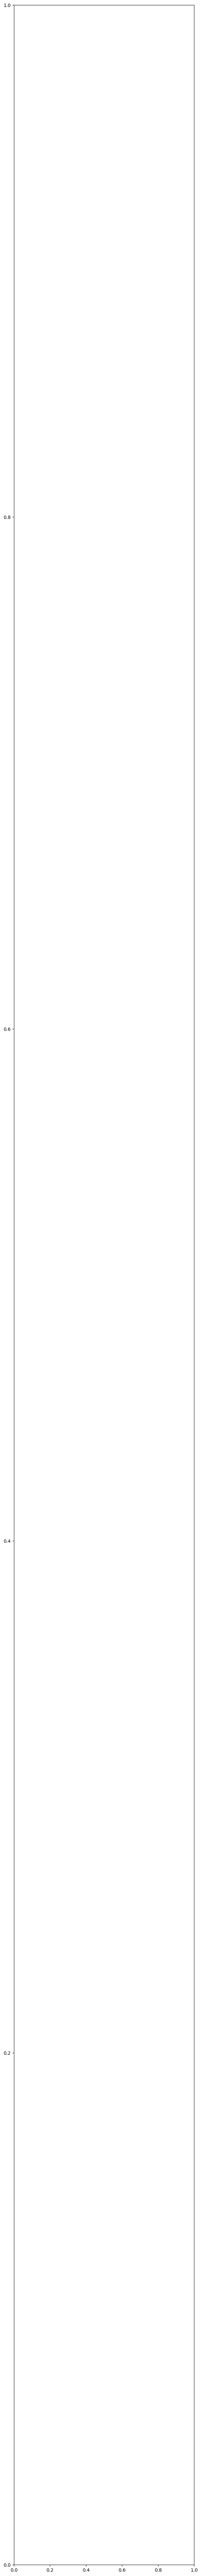

In [20]:
file_paths = [
    "local_test_transfer/NEON_D12_YELL_DP1_L036-1_20230715_directional_reflectance__envi_masked"
]

el_spectral.show_rgb(file_paths)